In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold

import xgboost as xgb
import lightgbm as lgb

from source import utility as ut
from source import transform as tr
from source.train import train_model
from source.report import plot_regression_predictions, plot_learning_curve, plot_feat_imp, plot_partial_dependence

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 100)

In [21]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

<AxesSubplot:>

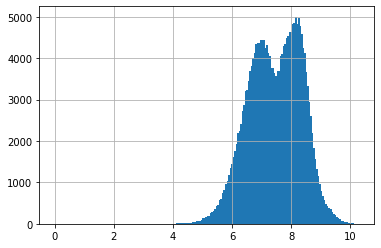

In [22]:
train_set.target.hist(bins=200)

<AxesSubplot:>

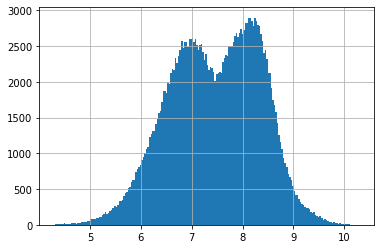

In [23]:
train_set[train_set.target > 4.3].target.hist(bins=200)

In [24]:
from sklearn.mixture import GaussianMixture

mixture = GaussianMixture(n_components=2, random_state=345).fit(train_set[train_set.target > 4.3][['target']])
means_hat = mixture.means_.flatten()
weights_hat = mixture.weights_.flatten()
sds_hat = np.sqrt(mixture.covariances_).flatten()

print(mixture.converged_)
print(means_hat)
print(sds_hat)
print(weights_hat)

True
[6.76704133 8.12924191]
[0.60742029 0.52070929]
[0.49261881 0.50738119]


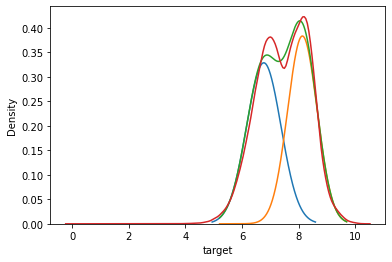

In [25]:
import scipy.stats as stats

mu1_h, sd1_h = means_hat[0], sds_hat[0]
x_axis = np.linspace(mu1_h-3*sd1_h, mu1_h+3*sd1_h, 1000)
plt.plot(x_axis, stats.norm.pdf(x_axis, mu1_h, sd1_h)/2)
mu2_h, sd2_h = means_hat[1], sds_hat[1]
x_axis = np.linspace(mu1_h-3*sd2_h, mu2_h+3*sd2_h, 1000)
plt.plot(x_axis, stats.norm.pdf(x_axis, mu2_h, sd2_h)/2)

plt.plot(x_axis, stats.norm.pdf(x_axis, mu2_h, sd2_h)/2 + stats.norm.pdf(x_axis, mu1_h, sd1_h)/2)
sns.kdeplot(train_set['target'])
plt.show()

In [26]:
weight_1 = stats.norm.pdf(train_set['target'], mu1_h, 2.5*sd1_h)
weight_2 = stats.norm.pdf(train_set['target'], mu2_h, 2.5*sd2_h)

In [27]:
weight_1

array([0.25536524, 0.22466758, 0.21941796, ..., 0.12398138, 0.21390435,
       0.20348708])

In [28]:
del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

folds = KFold(10, shuffle=True, random_state=541)

In [29]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler())])

Iteations for early stopping: [330, 208, 199, 302, 241, 307, 341, 236, 245, 266]
	Train set RMSE: 0.7712
	Test set RMSE: 0.8609


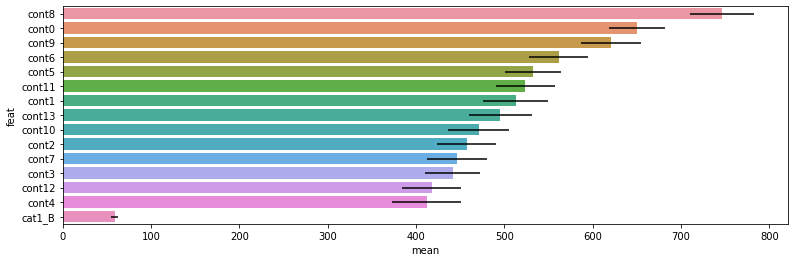

In [30]:
mod = lgb.LGBMRegressor(n_estimators=5000, n_jobs=5)

oof_1, pred_1, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, weight=weight_1, early_stopping=15, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof_1, sample_weight=weight_1)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred_1)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

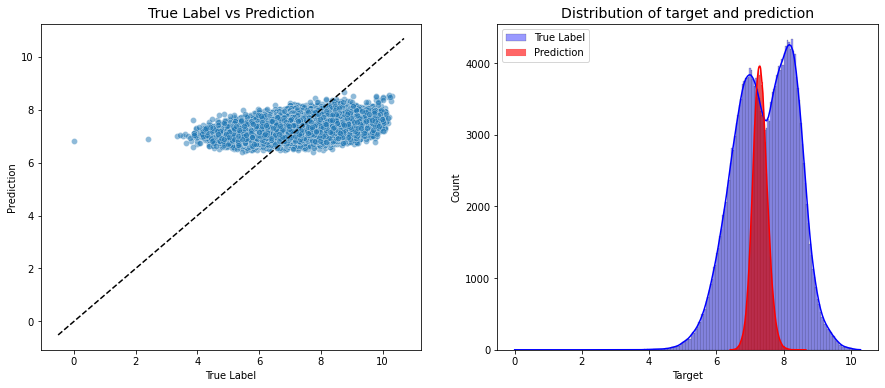

In [31]:
plot_regression_predictions(train_set, y, oof_1)

Iteations for early stopping: [325, 374, 388, 215, 388, 330, 446, 406, 355, 343]
	Train set RMSE: 0.7165
	Test set RMSE: 0.883


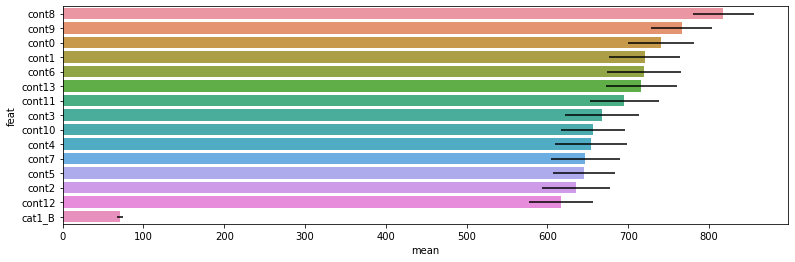

In [32]:
oof_2, pred_2, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, weight=weight_2, early_stopping=15, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof_2, sample_weight=weight_2)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred_2)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

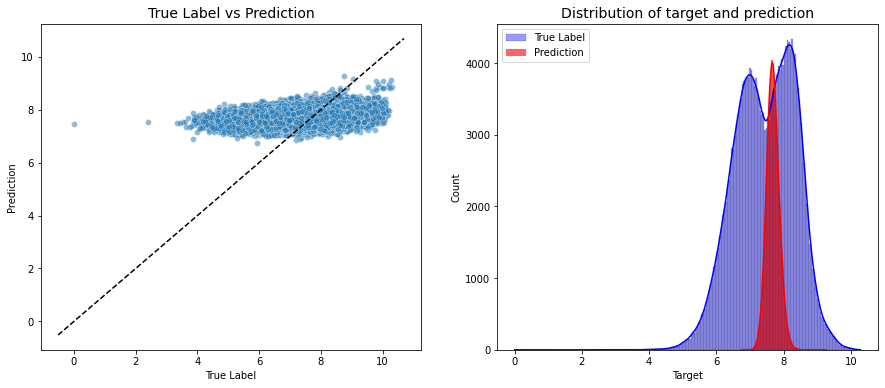

In [33]:
plot_regression_predictions(train_set, y, oof_2)

Iteations for early stopping: [191, 152, 132, 139, 182, 275, 232, 186, 180, 175]
	Train set RMSE: 0.8456
	Test set RMSE: 0.8454


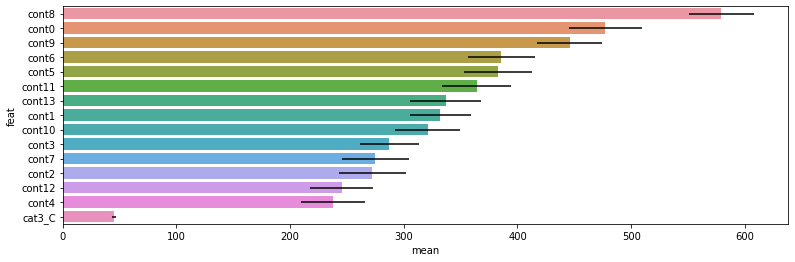

In [16]:
oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=25, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

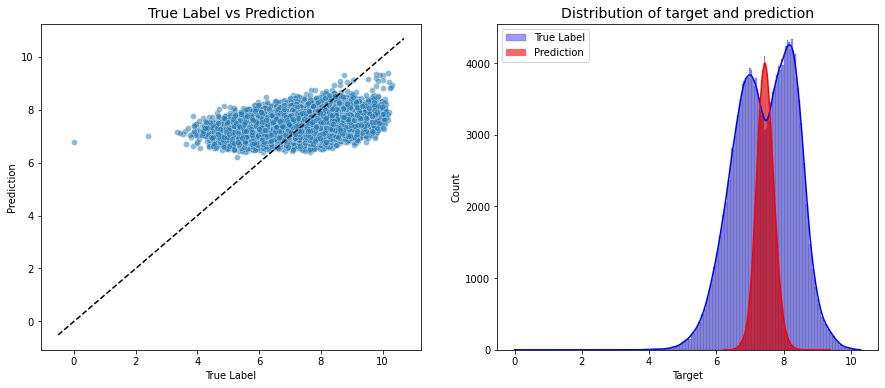

In [17]:
plot_regression_predictions(train_set, y, oof)

In [34]:
y_class = (y>(mu1_h+sd1_h)).astype(int)
y_class_test = (y_test>(mu1_h+sd1_h)).astype(int)

Iteations for early stopping: [237, 160, 144, 146, 140, 273, 198, 208, 210, 173]
	Train set RMSE: 0.6272
	Test set RMSE: 0.6298


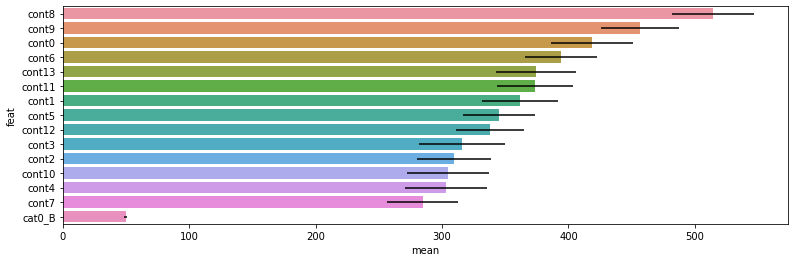

In [35]:
mod = lgb.LGBMClassifier(n_estimators=1000, n_jobs=5, reg_lambda=2, reg_alpha=3)

oof_c, pred_c, rep_res = train_model(train_set, test_set, y_class, full_pipe, mod, folds, early_stopping=100, predict_proba=True, eval_metric='roc_auc')

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(roc_auc_score(y_class, oof_c), 4)}')
print(f'\tTest set RMSE: {round(roc_auc_score(y_class_test, pred_c), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

	Train set RMSE: 0.8483
	Test set RMSE: 0.8484


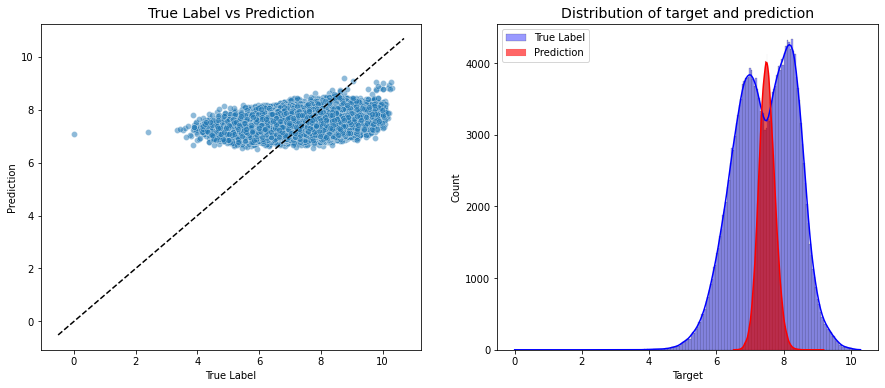

In [36]:
oof = oof_2 * oof_c + oof_1 * (1 - oof_c)
pred = pred_2 * pred_c + pred_1 * (1 - pred_c)

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_regression_predictions(train_set, y, oof)

	Train set RMSE: 0.7008
	Test set RMSE: 0.7003


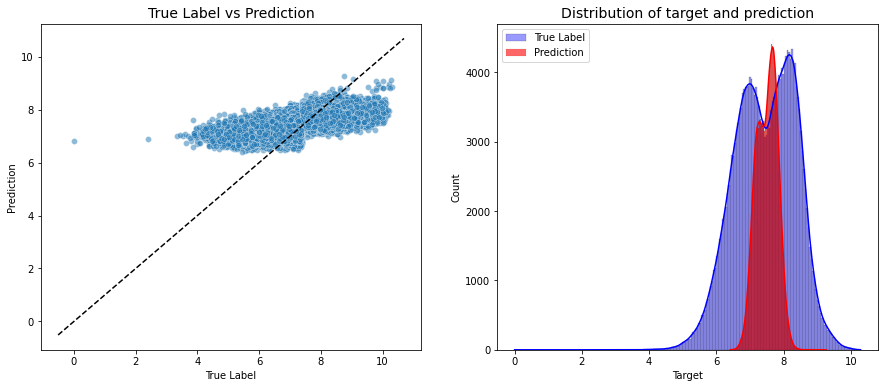

In [37]:
oof = oof_2 * y_class + oof_1 * (1 - y_class)
pred = pred_2 * y_class_test + pred_1 * (1 - y_class_test)

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_regression_predictions(train_set, y, oof)